# Stages for Solution Methods for MicroDSOPs

- Adapted by Sebastian Benthall from Tao Wang and Chris Carroll, 2022

The purpose here is to mirror the results from Chris's Carroll's [SolvingMicroDSOP lecture notes](https://llorracc.github.io/SolvingMicroDSOPs/) using HARK as closely as possible.

### Legacy: Some Python-related specifics: import necessary classes

The method takes advantage of Python's ability to bundle parameters with functionality via its object-oriented framework. We will import classes for CRRA utility, a class that discretes approximation to continuous distributions, and the "gothic" class that encapsulates functions $\mathfrak{v}$, $\mathfrak{v}'$, $\mathfrak{c}$, which all involve expectations.  

- The "utility" function class allows us to create an instance of a utility function, setting the risk aversion parameter once, and has a convenient "prime" method which executes the first derivative. 

- "DiscreteApproximation" fully implements an instance of the discrete approximation to a continuous distribution, taking advantage of SciPy's "frozen distribution" framework. It has a convenient way of calculating the expected value of any defined function of the random variable. 

- The "Gothic" class is bundled with methods that execute $\mathfrak{v}$, $\mathfrak{v}'$, $\mathfrak{c}$, and interpolations of each. They all involve calculating expectations of utility/marginal utility/value/marginal values, which will loop over some discretized values of the income shock. 


In [1]:
from copy import copy

# First import all necessary libraries.
import numpy as np  # Import Python's numeric library as an easier-to-use abbreviation, "np"
import pylab as plt  # Import Python's plotting library as the abbreviation "plt"
import scipy.stats as stats  # Import Scientific Python's statistics library
from numpy import log, exp  # for cleaner-looking code below
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import brentq  # Import the brentq root-finder
from scipy.optimize import minimize

import xarray as xr

from resources import (
    Utility,
    DiscreteApproximation,
    DiscreteApproximationTwoIndependentDistribs,
)

In [2]:
### for comparison purposes
## import some modules from HARK libararies
from HARK.ConsumptionSaving.ConsIndShockModel import init_lifecycle
from HARK.ConsumptionSaving.ConsPortfolioModel import (
    PortfolioConsumerType,
)

from HARK import distribution

## 0. Define Parameters, Grids, Utility Function 
Set up general parameters, as well as the first two major class instances: the utility function and the discrete approximation.

In [3]:
# Set up general parameters:

rho = 2.0  ### CRRA coefficient
beta = 0.96  ### discount factor
gamma = Gamma = np.array([1.0])  # permanent income growth factor
# A one-element "time series" array
# (the array structure needed for gothic class below)
R = 1.02  ## Risk free interest factor

# Define utility:
u = Utility(rho)


## 1. Discretization of the Income Shock Distribution 

- See detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#Discretizing-the-Distribution)

In [4]:
# Create a discrete approximation instance:

theta_sigma = 0.5
theta_mu = -0.5 * (theta_sigma**2)
theta_z = stats.lognorm(
    theta_sigma, 0, np.exp(theta_mu)
)  # Create "frozen" distribution instance
theta_grid_N = 7  ### how many grid points to approximate this continuous distribution

theta = DiscreteApproximation(
    N=theta_grid_N, cdf=theta_z.cdf, pdf=theta_z.pdf, invcdf=theta_z.ppf
)

# theta2 = DiscreteApproxima|tionToMeanOneLogNormal(N=theta_grid_N,sigma=sigma)
## (both are correct)



In [5]:
theta_dist = distribution.Lognormal(theta_mu, theta_sigma)

theta_approx = theta_dist.approx(7)

theta_approx.pmv
theta_approx.atoms

array([[0.40943488, 0.59312884, 0.73517448, 0.88368378, 1.06261303,
        1.3198218 , 1.99614319]])

In [6]:
## Other parameters


# Self-imposed lower bounds(for period T)
# the minimum asset (the maximum debt) is the discounted value of lowest possible transitory income shock
## the so called "natural borrowing constraint"

self_a_min = -np.min(theta_approx.atoms) * gamma[0] / R  # self-imposed minimum a


## A Gothic Class


The main code used to implement the solution can be found in the "Gothic" class definition, which contains methods implementing the $\mathfrak{v}$, $\grave{\mathfrak{v}}$  (linear interpolation of $\mathfrak{v}$), $\mathfrak{v}'$, $\grave{\mathfrak{v}}'$, and $\mathfrak{c}$, $\grave{\mathfrak{c}}'$ functions. These are essentially expectated value, expected marginal value, and expected marginal utility, respectively, as the functions of next-period value and consumption policy functions. 

Since these functions all involve computing expectations, we bundle them together as a Gothic class and use an instance of the class below to solve a consumption function; this mirrors Sections 5.5 - 5.9 in the [lecture note](https://llorracc.github.io/SolvingMicroDSOPs/).


#### Import and create instance of the "Gothic" class

Create a particular instance of the "Gothic" class, using $u$, $\beta$, $\rho$, $\gamma$, and the $\theta$-approximation.  

In [7]:
from gothic_class import Gothic

gothic = Gothic(u, beta, rho, gamma, R, theta)


## 2. Solving the Model by Value Function Maximization

- See detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#x1-70005.2)

First, we numerically maximize the value functions over a very fine set of grid points of the market resource (m) to get the benchmark solution to consumption policy and value function. We use it to approximate the "accurate" solution in this notebook. 

This approach will be improved in different ways in the sections below.

In [8]:
m_min, m_max, m_size = -0.1, 4.0, 5

# include some negative values


In [9]:
### solve the model with very fine mVec_fine

cVec = []  # Start with an empty list. Lists can hold any Python object.
vVec = []  # Empty list for values

## fine grid of m
mVec_fine = np.linspace(m_min, m_max, 100)

for m in mVec_fine:
    c_max = m + gamma[0] * theta.X[0] / R  ## minimum total wealth

    nvalue = lambda c: -(
        u(c) + gothic.V(m - c)
    )  ## Define the a one-line (negative) value function of the T-1 period
    ## negative value to be minimized
    ## notice here V only takes saving at T-1 as input since this is the T-1 period
    ## the consumption policy at T is trivial
    ## for this m, find the c that maximizes the value from T-1 and T
    res = minimize(
        nvalue,
        np.array([0.3 * m]),  ## an initial guess of the c
        method="trust-constr",  ## trust-constr turns out a good constrained optimization algorithm
        bounds=(
            (1e-12, 0.999 * c_max),
        ),  ## consumption has to be between 0.0 and c_max
        options={"gtol": 1e-12, "disp": False},
    )
    c = res["x"][0]  # maximizer of the value
    v = -res["fun"]  ## value
    cVec.append(c)
    vVec.append(v)


/home/sb/projects/HARK/hark-env/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Text(0, 0.5, '$c(m_{T-1})$')

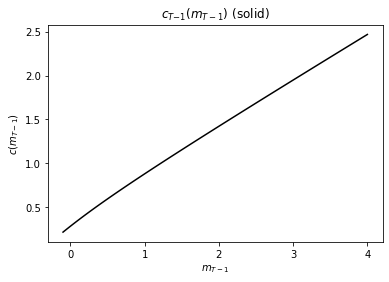

In [10]:
# Look at the solution

plt.title(r"$c_{T −1}(m_{T-1})$ (solid)")
plt.plot(mVec_fine, cVec, "k-")  ## c(m)
plt.xlabel(r"$m_{T-1}$")
plt.ylabel(r"$c(m_{T-1})$")


Then, solve the model with only a small number of grid points of m.

In [11]:
# very sparse m_grid

mVec = np.linspace(m_min, m_max, m_size)


In [12]:
cVec0 = []  # Start with empty list. Lists can hold any Python object.
vVec0 = []

for m in mVec:
    c_max = m + gamma[0] * theta.X[0] / R

    nvalue = lambda c: -(
        u(c) + gothic.V(m - c)
    )  # Define the a one-line value function of the T-1 period

    res = minimize(
        nvalue,
        np.array([0.2 * m]),
        method="trust-constr",
        bounds=((1e-12, 0.999 * c_max),),
        options={"gtol": 1e-12, "disp": False},
    )
    c = res["x"][0]  # maximizer of the value
    v = -res["fun"]  ## value
    cVec0.append(c)
    vVec0.append(v)

print(cVec0)  # Look at the consumption from the list.


[0.21504381741906864, 0.837648803274424, 1.3951569960150094, 1.9353194110790921, 2.4682182755608326]


## 2a. Staging an Intervention

Herein we begin to start defining the problem in terms of abstract Bellman Stages.

In [13]:
from HARK.stage import Stage
from HARK.utilities import CRRAutilityP_inv
from typing import Any, Callable, Mapping, Sequence

In [14]:
beta, rho

stage = Stage(
    transition = lambda x, k, a : {'a' : x['m'] - a['c']},
    transition_der = lambda x, k, a : -1,  ## Used in FOC method, step 5
    transition_inv = lambda y, a : {'m' : y['a'] + a['c']},  ## Used in EGM method, step 8
    reward = lambda x, k, a : u(a['c']),
    reward_der = lambda x, k, a: u.prime(a['c']),
    reward_der_inv = lambda uP : (CRRAutilityP_inv(uP, rho),),

    #shocks = {
    #    'psi' :
    #    'theta' : 
    #}

    inputs = ['m'], 
    actions = ['c'],
    outputs = ['a'],
    action_upper_bound = lambda x, k: (x['m'] + gamma[0] * theta.X[0] / R,),

    #discount = beta, <-- Removed because beta is in gothic V!
    
    ##### Inputs to optimizers, interpolators, solvers...
    optimizer_args = {
        'method' : 'Nelder-Mead',
        'options' : {
            'maxiter': 1e3,
            #'disp' : True
        }
    },
    
    ## TODO: Add value function transform
)

Here, we use the pre-defined $\mathfrak{v}$ as the end-of-stage value function $v_y$.

Note that because $\mathfrak{v}$ _includes_ the discount factor $\beta$, we will not add it to the stage definition.

In [15]:
def consumption_v_y(y : Mapping[str,Any]):
    return  gothic.V(y['a'])

sol = stage.solve(
    {'m' : mVec},
    {},
    v_y = consumption_v_y
)

Grid size: 5.0


/home/sb/projects/HARK/examples/BellmanStages/SolvingMicroDSOPs/resources.py:941: RuntimeWarning: divide by zero encountered in double_scalars
  return( c**(1.0 - self.gamma) / (1.0 - self.gamma) )


The stage policy solver returns the optimal policy as an xarray.

In [16]:
sol.dataset['pi*']

<xarray.DataArray 'pi*' (m: 5)>
array([0.2150625, 0.837625 , 1.3951875, 1.9353125, 2.4681875])
Coordinates:
  * m        (m) float64 -0.1 0.925 1.95 2.975 4.0

There are very small discrepancies between the stage solver and the SolvingMicroDSOP code! These might be attributed to the different choice of numerical solver.

In [17]:
sol.dataset['pi*'] - cVec0

<xarray.DataArray 'pi*' (m: 5)>
array([ 1.86825809e-05, -2.38032744e-05,  3.05039850e-05, -6.91107909e-06,
       -3.07755608e-05])
Coordinates:
  * m        (m) float64 -0.1 0.925 1.95 2.975 4.0

In [18]:
sol.pi_star({'m' : [0,1,2]}, {})

{'c': 0.275800304878049}

## 3. An Interpolated Consumption Function

Although we have now solved optimal c above for a finite set of predetermined gridpoints of $m$, how do we know the consumption value at different values of $m$ not among these grid points? We need interpolation.

- See detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#x1-80005.3)


The interpolated consumption function is not very different from the true consumption function. (See Figure 2)

Text(0.5, 1.0, '$c_{T −1}(m_{T-1})$ (solid) versus $\\grave c_{T-1}(m_{T-1})$(dashed)')

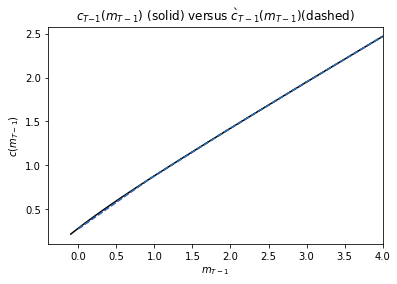

In [19]:
## interpolated c func based on the solution from a small number of m grids

cFunc0 = InterpolatedUnivariateSpline(mVec, cVec0, k=1)
mVec_int = np.linspace(0.0, 4.0, 50)
cVec_int = cFunc0(mVec_int)

######################################
### Figure 2
######################################
plt.plot(mVec_int, 
         sol.dataset['pi*'].interp( ## Accessing this solution is more awkward than it should be.
             {**{'m' : mVec_int}, **{}},
              kwargs={"fill_value": 'extrapolate'})
         , 'm--')
plt.plot(mVec_fine, cVec, "k-")  ## c(m)
plt.plot(mVec_int, cVec_int, "--")  ## 'c(m)
plt.xlim(self_a_min, 4.0)
plt.xlabel(r"$m_{T-1}$")
plt.ylabel(r"$c(m_{T-1})$")
plt.title(r"$c_{T −1}(m_{T-1})$ (solid) versus $\grave c_{T-1}(m_{T-1})$(dashed)")


Does the interpolation of the value function work as well as that for consumption function?

It turns out that the interpolated value function only poorly approximates its true counterpart.(See Figure 3) The reason for this is that value function is highly concave.

Text(0.5, 1.0, '$v_{T −1}(m_{T −1})$ (solid) versus $\\grave v_{T-1}(m_{T-1})$ (dashed)')

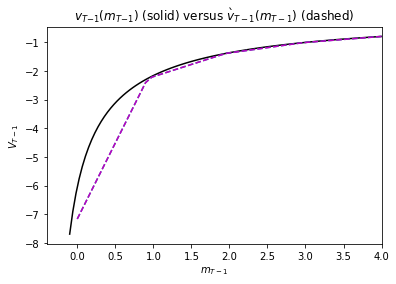

In [20]:
## interpolated v func
vFunc0 = InterpolatedUnivariateSpline(mVec, vVec0, k=1)

vVec_int = vFunc0(mVec_int)

#########################################
### Figure 3
########################################

plt.plot(mVec_fine, vVec, "k-")  ## v(m)
plt.plot(mVec_int, vVec_int, "--")  ## 'v(m)
plt.plot(mVec_int, 
         sol.dataset['v_x'].interp(
             {**{'m' : mVec_int}, **{}},
              kwargs={"fill_value": 'extrapolate'})
         , 'm--')

plt.xlim(self_a_min, 4.0)
plt.xlabel(r"$m_{T-1}$")
plt.ylabel(r"$V_{T-1}$")
plt.title(r"$v_{T −1}(m_{T −1})$ (solid) versus $\grave v_{T-1}(m_{T-1})$ (dashed)")


## 4. Interpolating Expectations

- See detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#Interpolating-Expectations)

The program above turns out to be __inefficient__. For every value of $m_{T −1}$ the program must calculate the utility consequences of various possible choices of $c_{T−1}$ as it searches for the best choice. But for any given value of $m_{T-1}-c_{T-1}=a_{T−1}$, there is a good chance that the program may end up calculating the corresponding v many times while maximizing utility from different $m_{T −1}$’s. 

An improvement can be made: we can construct a direct numerical approximation to the value function based on a vector of predefined $a=m-c$ grid and use the interpolated function to calculate $\mathfrak{v}_{T-1}$ for a given $a$. 

In [21]:
# A grid:
a_min, a_max, a_size = 0.0, 4.0, 5
aVec = np.linspace(a_min, a_max, a_size)

## gothiv v values for a vector of a
## get the values from a finely constructed a
gothicvVec = np.array([gothic.V(a) for a in aVec])
## then create an interpolation of that to use in solving the models
gothicvFunc0 = InterpolatedUnivariateSpline(
    aVec, gothicvVec, k=1
)  ## this is the interpolated gothic v func

## solve the model again

cVec1 = []  # Start with empty list. Lists can hold any Python object.
vVec1 = []

for m in mVec:
    c_max = m + gamma[0] * theta.X[0] / R

    ## Below, instead of using gothic.V func, we use the interpolated gothicvFun
    nvalue = lambda c: -(u(c) + gothicvFunc0(m - c))
    ##################################################################################################
    #### Notice here, instead of drawing Gothic.V function, we use the interpolation of it gothicvFunc0
    ###################################################################################################

    res = minimize(
        nvalue,
        np.array([0.3 * m]),
        method="trust-constr",
        bounds=((1e-12, 0.999 * c_max),),
        options={"gtol": 1e-12, "disp": False},
    )
    c = res["x"][0]  # maximizer of the value
    v = -res["fun"]  ## value
    cVec1.append(c)
    vVec1.append(v)

print(cVec1)


/home/sb/projects/HARK/hark-env/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


[0.3011022415204137, 1.188019168262725, 1.188019151792427, 1.9749999891135241, 2.3724195081017445]


### 4a. Using the Stage with interpolated value function

In [22]:
def consumption_v_y_interp(y : Mapping[str,Any]):
    return  gothicvFunc0(y['a'])

sol_4 = stage.solve(
    {'m' : mVec},
    {},
    v_y = consumption_v_y_interp
)

Grid size: 5.0


/home/sb/projects/HARK/examples/BellmanStages/SolvingMicroDSOPs/resources.py:941: RuntimeWarning: divide by zero encountered in double_scalars
  return( c**(1.0 - self.gamma) / (1.0 - self.gamma) )


**WARNING: Is the difference in consumption at the 0.925 point too much?!?!**

In [23]:
sol_4.dataset['pi*'] - cVec1

<xarray.DataArray 'pi*' (m: 5)>
array([ 3.04508172e-04,  1.38387581e-01, -1.91517924e-05,  1.08864784e-08,
        1.79918983e-05])
Coordinates:
  * m        (m) float64 -0.1 0.925 1.95 2.975 4.0

The interpolated functions are of course identical at the gridpoints chosen for $a_{T− 1}$   and they appear reasonably close except in the region below $m_{T −1} = 1.0$. (See Figure 4)

Text(0.5, 1.0, 'End of period value $\\mathfrak{v}_{T-1}(a_{T-1})$ (solid) versus $\\grave \\mathfrak{v}_{T-1}(a_{T-1})$ (dashed)')

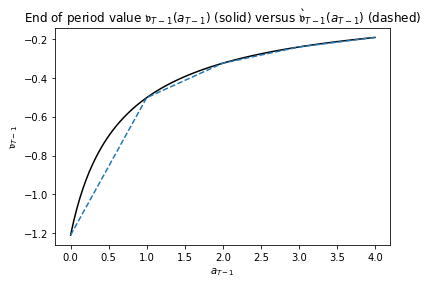

In [24]:
#################
### Figure 4
#################

### get real gothic v
aVec_fine = np.linspace(a_min, a_max, 100)
gothicvVec_fine = np.array([gothic.V(a) for a in aVec_fine])

# plt.plot(mVec,vVec1,'-.')
plt.plot(aVec_fine, gothicvVec_fine, "k-")
plt.plot(aVec, gothicvVec, "--")

plt.xlabel(r"$a_{T-1}$")  ### this is different from lecture note
plt.ylabel(r"$\mathfrak{v}_{T-1}$")
plt.title(
    r"End of period value $\mathfrak{v}_{T-1}(a_{T-1})$ (solid) versus $\grave \mathfrak{v}_{T-1}(a_{T-1})$ (dashed)"
)


Nevertheless, the resulting consumption rule obtained when $\grave{\mathfrak{v}}_{T-1}(a_{T-1})$ is used instead of $\mathfrak{v}_{T −1}(a_{T−1})$  is surprisingly bad. (See Figure 5)

Text(0.5, 1.0, '$c_{T-1}(m_{T-1})$ (solid) versus $\\grave c_{T-1}(m_{T-1})$ (dashed)')

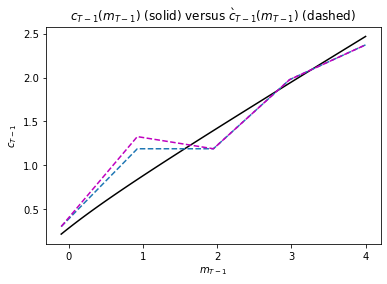

In [25]:
####################
### Figure 5
####################

plt.plot(mVec_fine, cVec, "k-")
plt.plot(mVec, cVec1, "--")

plt.plot(mVec, 
         sol_4.dataset['pi*'].interp(
             {**{'m' : mVec}, **{}},
              kwargs={"fill_value": 'extrapolate'}),
         'm--')

plt.xlabel(r"$m_{T-1}$")
plt.ylabel(r"$c_{T-1}$")
plt.title(r"$c_{T-1}(m_{T-1})$ (solid) versus $\grave c_{T-1}(m_{T-1})$ (dashed)")


## 5. Value Function versus the First Order Condition

- See more detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#Value-Function-versus-First-Order-Condition)

Our difficulty is caused by the fact that the consumption choice is governed by the marginal value function, not by the level of the value function (which is what we tried to approximate). 

This leads us to an improved approach to solving consumption policy by working with marginal utility/values via the  first-order conditions(FOC). For every exogenously set m grid, we could find the root of the FOC. 

\begin{equation}
u'(c_{T-1}(m_{T-1})) = \mathfrak{v}'(m_{T-1}-c_{T-1}(m_{T-1}))
\end{equation}

In [26]:
##########################
### Figure 6 (omitted here)
##########################

# u′(c) versus v′_{T −1}(3 − c), v′_{T −1}(4 − c), v`′_{T −1}(3 − c), v`′_{T −1}(4 − c)


Now solve for consumption using FOCs instead of value function maximization. 

In [27]:
cVec2 = []  # Start with empty list.
for m in mVec:
    mintotwealth = m + gamma[0] * theta.X[0] / R
    foc_condition = lambda c: u.prime(c) - gothic.VP_Tminus1(
        m - c
    )  # Define the a one-line function for the FOC
    c = brentq(foc_condition, 1e-12, 0.999 * mintotwealth)  # Zero-find on the FOC
    cVec2.append(c)

print(cVec2)  # Look at the consumption from the list.


[0.21504382477195785, 0.8376488103781283, 1.3951570021328097, 1.935319420429008, 2.468218301570615]


### 5a. Stages with FOC

In [28]:
def consumption_v_y_der(y : Mapping[str,Any]):
    return gothic.VP_Tminus1(y['a'])

pi_star, q_der, y_data = stage.optimal_policy_foc(
    {'m' : mVec},
    v_y_der = consumption_v_y_der
)

pi_star

Grid size: 5.0


/home/sb/projects/HARK/examples/BellmanStages/SolvingMicroDSOPs/resources.py:949: RuntimeWarning: divide by zero encountered in power
  return(c**-self.gamma)


<xarray.DataArray (m: 5)>
array([0.21504382, 0.83764881, 1.395157  , 1.93531942, 2.4682183 ])
Coordinates:
  * m        (m) float64 -0.1 0.925 1.95 2.975 4.0

The linear interpolating approximation looks roughly as good (or bad) for the marginal value function as it was for the level of the value function.

Text(0.5, 1.0, '$\\mathfrak{v}^{\\prime}(a_{T-1})$ (solid) and $\\grave \\mathfrak{v}^{\\prime}(a_{T-1})$ (dashed)')

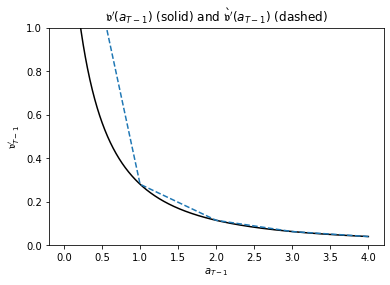

In [29]:
########################
## Figure 7
########################


# get the VP for fine grids of a

aVec_fine = np.linspace(0.0001, 4, 1000)
vpVec_fine = [gothic.VP_Tminus1(a) for a in aVec_fine]

# Examine the interpolated GothicVP function:
vpVec = [gothic.VP_Tminus1(a) for a in aVec]

## this is the interpolated gothic v func
gothicvpFunc = InterpolatedUnivariateSpline(aVec, vpVec, k=1)

plt.plot(aVec_fine, vpVec_fine, "k-")  ## gothic v'(a)
plt.plot(aVec, gothicvpFunc(aVec), "--")  ## 'gothic v'(a)
plt.ylim(0.0, 1.0)
plt.xlabel(r"$a_{T-1}$")
plt.ylabel(r"$\mathfrak{v}^{\prime}_{T-1}$")
plt.title(
    r"$\mathfrak{v}^{\prime}(a_{T-1})$ (solid) and $\grave \mathfrak{v}^{\prime}(a_{T-1})$ (dashed)"
)


The new consumption function (long dashes) is a considerably better approximation of the true consumption function (solid) than was the consumption function obtained by approximating the level of the value function (short dashes). (See Figure 8).

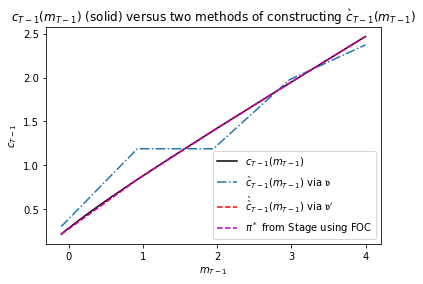

In [30]:
#########################
## Figure 8
########################

plt.plot(mVec_fine, cVec, "k-", label=r"$c_{T-1}(m_{T-1})$")  ## real c func
plt.plot(
    mVec, cVec1, "-.", label=r"$\grave c_{T-1}(m_{T-1})$ via $\mathfrak{v}$"
)  ## interpolated c func based on interpolated level of value
plt.plot(
    mVec,
    cVec2,
    "r--",
    label=r"$\grave \grave c_{T-1}(m_{T-1})$ via $\mathfrak{v}^{\prime}$",
)  ## interpolated c func based on interpolated marginal value

plt.plot(mVec, 
         pi_star.interp( ## Accessing this solution is more awkward than it should be.
             {**{'m' : mVec}, **{}},
              kwargs={"fill_value": 'extrapolate'}),
         'm--', label="$\pi^*$ from Stage using FOC")

plt.xlabel(r"$m_{T-1}$")
plt.ylabel(r"$c_{T-1}$")
plt.title(
    r"$c_{T-1}(m_{T-1})$ (solid) versus two methods of constructing $\grave c_{T-1}(m_{T-1})$"
)
plt.legend(loc=4)


The numerical values are very close.

In [31]:
pi_star.interp( ## Accessing this solution is more awkward than it should be.
             {**{'m' : mVec}, **{}},
              kwargs={"fill_value": 'extrapolate'}) - cVec2

<xarray.DataArray (m: 5)>
array([ 2.77555756e-17, -5.75095527e-14,  5.55111512e-14,  6.66133815e-15,
        8.88178420e-16])
Coordinates:
  * m        (m) float64 -0.1 0.925 1.95 2.975 4.0

## 6. Transformation

- See more detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#Transformation)


However, even the new-and-improved consumption function diverges from the true solution, especially at lower values of m. That is because the linear interpolation does an increasingly poor job of capturing the nonlinearity of $v′_{T −1}(a_{T −1})$ at lower and lower levels of a.

In [32]:
cVec3 = []
cVec4 = []

for a in aVec:
    c = gothic.C_Tminus1(a)
    cVec3.append(c)

for a in aVec_fine:
    c = gothic.VP_Tminus1(a) ** (-1 / rho)
    cVec4.append(c)


## 7. The Self-Imposed ‘Natural’ Borrowing Constraint and the $a_{T−1}$ Lower Bound

- See more detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#The-Self-Imposed-Natural-Borrowing-Constraint-and-the-a-Lower-Bound)

As the marginal utility from zero consumption goes to infinity, the agents will try to have at least a little of consumption in the "worst" case. This cutting-edge case happens when the $a_{T-1}$ is exactly equal to the present value of the worst possible transitory shock. As a result, there is a self-imposed borrowing constraint, i.e. a lower bound for the value of $a_{T-1}$. 

In general, preset grids of a may not necessarily include this point. We hence insert this self-imposed bound to the beginning of the list of grid to make sure the consumption policy close to this bound is correctly interpolated. 

In [33]:
## Augment the mVec and cVec with one point with bottom

aVecBot = np.insert(aVec, 0, self_a_min)
cVec3Bot = np.insert(cVec3, 0, 0.0)

aVecBot_fine = np.insert(aVec_fine, 0, self_a_min)
cVec4Bot = np.insert(cVec4, 0, 0.0)


This ﬁgure well illustrates the value of the transformation (Section 6): The true function is close to linear, and so the linear approximation is almost indistinguishable from the true function except at the very lowest values of $a_{T−1}$. (See Figure 9)

### 7a. TODO: Show how to add point to solution up front.

In [34]:
stage.solution_points = xr.Dataset(
        data_vars={
            #'v_x' : (["m"], [-float('inf')]),
            #'v_x_der' : (["m"], [float('inf')]),
            'pi*' : (["m"], [0]),
            #'q' : (["m"], [-float('inf')]),
        },
        coords={
            'm' : (["m"], [self_a_min]),
        }
    )

def consumption_v_y_der(y : Mapping[str,Any]):
    return gothic.VP_Tminus1(y['a'])


## TODO: An optimal policy solver that starts with a Y grid.
pi_star, q_der, y_data = stage.optimal_policy_foc(
    {'m' : mVec},
    v_y_der = consumption_v_y_der
)

## TODO: Move more of this into general HARK.stage code.
## Optimal_policy to return a DataSet rather than multiple DataArrays?
pi_star.coords['a'] = y_data
pi_star_y = pi_star.swap_dims({"m": "a"})

Grid size: 5.0


/home/sb/projects/HARK/examples/BellmanStages/SolvingMicroDSOPs/resources.py:949: RuntimeWarning: divide by zero encountered in power
  return(c**-self.gamma)


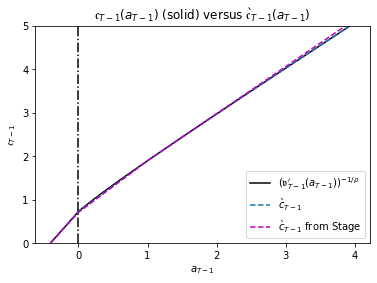

In [35]:
##############
## Figure 9
##############

plt.plot(
    aVecBot_fine,
    cVec4Bot,
    "k-",
    label=r"$(\mathfrak{v}^{\prime}_{T-1}(a_{T-1}))^{-1/\rho}$",
)
plt.plot(aVecBot, cVec3Bot, "--", label=r"$\grave c_{T-1}$")

### Wrong -- this should be plotting:
###       -- x: a -- assets (not m!)
###       -- y: c given a (not policy )
plt.plot(
    aVecBot,
    pi_star_y.interp(
             {**{'a' : aVecBot}, **{}},
              kwargs={"fill_value": 'extrapolate'}),
    "m--",
    label=r"$\grave c_{T-1}$ from Stage"
)

plt.xlabel(r"$a_{T-1}$")
plt.ylabel(r"$\mathfrak{c}_{T-1}$")
plt.ylim(0.0, 5.0)
plt.vlines(0.0, 0.0, 5.0, "k", "-.")
plt.title(
    r"$\mathfrak{c}_{T-1}(a_{T-1})$ (solid) versus $\grave \mathfrak{c}_{T-1}(a_{T-1})$"
)
plt.legend(loc=4)


There are some discrepancies in the numerical results. Note that we have computed values fro $\pi^*_y$ only up to $a = 1.532$ so this is forcing extrapolation outside of the computed range.

In [36]:
pi_star_y.interp(
             {**{'a' : aVecBot}, **{}},
              kwargs={"fill_value": 'extrapolate'}) - cVec3Bot

<xarray.DataArray (a: 6)>
array([ 0.        , -0.02120626, -0.00071972,  0.00738385,  0.0357097 ,
        0.07299383])
Coordinates:
    m        (a) float64 -0.4014 0.7025 2.891 4.975 7.058 9.141
  * a        (a) float64 -0.4014 0.0 1.0 2.0 3.0 4.0

In [37]:
pi_star_y

<xarray.DataArray (a: 6)>
array([0.        , 0.21504382, 0.83764881, 1.395157  , 1.93531942,
       2.4682183 ])
Coordinates:
    m        (a) float64 -0.4014 -0.1 0.925 1.95 2.975 4.0
  * a        (a) float64 -0.4014 -0.315 0.08735 0.5548 1.04 1.532

In [38]:
## compute gothic_v' as c^(-rho)

vpVec_fromc = lambda a: InterpolatedUnivariateSpline(aVecBot, cVec3Bot, k=1)(a) ** (
    -rho
)


And when we calculate $\grave{\grave{\mathfrak{v}}}^{\prime}_{T-1}(a_{T−1})$ as $[\grave{\mathfrak{c}}_{T-1}(a_{T-1})]^{-\rho}$  (dashed line) we obtain a much closer approximation of $\mathfrak{v}^{\prime}_{T-1}(a_{T-1})$. (See Figure 10)

Text(0.5, 1.0, '$\\mathfrak{v}^{\\prime}_{T-1}(a_{T-1})$ (solid) versus $\\grave \\grave \\mathfrak{v}^{\\prime}(a_{T-1})$\n constructed using $\\grave \\mathfrak{c}_{T-1}$ (dashed)')

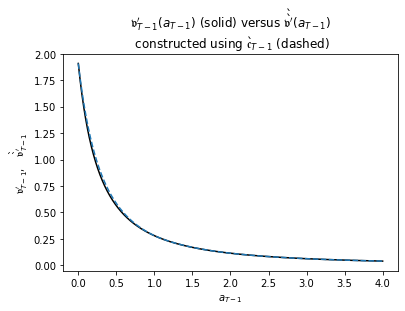

In [39]:
#############################
## Figure 10
############################

plt.plot(aVec_fine, vpVec_fine, "k-")
plt.plot(aVec_fine, vpVec_fromc(aVec_fine), "--")

plt.xlabel(r"$a_{T-1}$")
plt.ylabel(
    r"$\mathfrak{v}^{\prime}_{T-1},\quad \grave \grave \mathfrak{v}^{\prime}_{T-1}$"
)
plt.title(
    r"$\mathfrak{v}^{\prime}_{T-1}(a_{T-1})$ (solid) versus $\grave \grave \mathfrak{v}^{\prime}(a_{T-1})$"
    + "\n constructed using $\grave \mathfrak{c}_{T-1}$ (dashed)"
)


## 8. Endogenous Gridpoints: Use Algebra to Find $c_{T-1}(m_{T-1})$

- See more detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#The-Method-of-Endogenous-Gridpoints)

We now take advantage of the fact that 

$$m_{T−1,i} = c_{T−1,i} + a_{T−1,i}\;\;\forall a_{i} \in \mathbb{A}_{grid},$$

to find optimal consumption as a function of $m$, once we have the optimizing choice and $a$ in hand. 



In [40]:
# Create the first point in the consumption function:
mVec_egm = [self_a_min]  ## consumption is zero therefore a = m here
cVec_egm = [0.0]

for a in aVec:
    c = gothic.C_Tminus1(a)
    m = c + a
    cVec_egm.append(c)
    mVec_egm.append(m)

# Set up the interpolation:
cFunc_egm = InterpolatedUnivariateSpline(mVec_egm, cVec_egm, k=1)


### 8a. Stages support EGM



In [41]:
pi, pi_y = stage.optimal_policy_egm(
    y_grid = {'a' : aVec},
    v_y_der = consumption_v_y_der
)
                                    
pi 

<xarray.DataArray (m: 6)>
array([0.        , 0.7237011 , 1.89183061, 2.9678705 , 4.02244989,
       5.06807101])
Coordinates:
  * m        (m) float64 -0.4014 0.7237 2.892 4.968 7.022 9.068

Compared to the approximate consumption functions illustrated in Figure 8 $\grave c_{T-1}$ is quite close to the actual consumption function. (See Figure 11)

Text(0.5, 1.0, '$c_{T-1}(m_{T-1})$ (solid) versus $\\grave c_{T-1}(m_{T-1})$ using EGM')

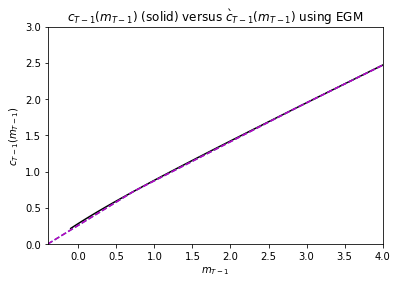

In [42]:
####################
## Figure 11 ####
####################


# Plot the first consumption function (c_{T-1}). We will plot the rest in the loop below.
# plt.plot(mVec_egm, mVec_egm, color='0.7')    # Gray 45 deg line
# plot_m_max = 5.0                               # Max plotting point.
# plot_c_max = cFunc_egm(plot_m_max)
temp_c_values = cFunc_egm(mVec_egm)

plt.plot(mVec_fine, cVec, "k-")
plt.plot(mVec_egm, temp_c_values, "--")

plt.plot(mVec_egm, pi.interp({'m' : mVec_egm }), "m--")

plt.xlim(self_a_min, 4.0)
plt.ylim(0.0, 3.0)
plt.xlabel(r"$m_{T-1}$")
plt.ylabel(r"${c}_{T-1}(m_{T-1})$")
plt.title(r"$c_{T-1}(m_{T-1})$ (solid) versus $\grave c_{T-1}(m_{T-1})$ using EGM")


The numerical results are exactly identical.

In [43]:
pi.interp({'m' : mVec_egm}) -  temp_c_values

<xarray.DataArray (m: 6)>
array([0., 0., 0., 0., 0., 0.])
Coordinates:
  * m        (m) float64 -0.4014 0.7237 2.892 4.968 7.022 9.068

In [44]:
type(pi.interp({'m' : mVec_egm}))

xarray.core.dataarray.DataArray

In [45]:
pi.interp(xarray) 

pi.interp(m = data) 

pi.interp(statedata) 
decision_rule.compute(statedata) 

pi.interp({'states' : xarray({'m' : data})}) 
pi.interp({states = statedata}) ## ???

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (1525970484.py, line 9)

In [ ]:
### 

pi.interp({'m' : mVec_egm })

In [ ]:
temp_c_values

## 9. Improve the $\mathbb{A}_{grid}$

- See more detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#Improving-the-a-Grid)

We will improve our $\mathbb{A}_{grid}.$ 

We use a multi-exponential growth rate (that is $e^{e^{e^{...}}}$ for some number of exponentiations n) from each point to the next point is constant (instead of, as previously, imposing constancy of the absolute gap between points).

In [ ]:
### This function creates multiple-exp a_grid


def setup_grids_expMult(minval, maxval, size, timestonest=20):
    i = 1
    gMaxNested = maxval
    while i <= timestonest:
        gMaxNested = np.log(gMaxNested + 1)
        i += 1

    index = gMaxNested / float(size)

    point = gMaxNested
    points = np.empty(size)
    for j in range(1, size + 1):
        points[size - j] = np.exp(point) - 1
        point = point - index
        for i in range(2, timestonest + 1):
            points[size - j] = np.exp(points[size - j]) - 1
    a_grid = points
    return a_grid


In [ ]:
def set_up_improved_EEE_a_grid(minval, maxval, size):
    gMinMin = 0.01 * minval
    gMaxMax = 10 * maxval
    gridMin = log(1 + log(1 + log(1 + gMaxMax)))
    gridMax = (
        log(1 + log(1 + log(1 + gMaxMax))) - log(1 + log(1 + log(1 + gMinMin)))
    ) / size
    index = (
        log(1 + log(1 + log(1 + gMinMin)))
        + (log(1 + log(1 + log(1 + gMaxMax))) - log(1 + log(1 + log(1 + gMinMin))))
        / size
    )
    i = 1
    point = 0
    points = []
    while point < gridMin:
        point = point + index
        points.append(point)
        i += 1

    new_a_grid = exp(exp(exp(points) - 1) - 1) - 1
    return new_a_grid


In [ ]:
### create the new grid with multiple exponential approach

a_size_splus = 20  ## just need a little more than 5 to cover the whole range of a well

aVec_eee = setup_grids_expMult(a_min, a_max, a_size_splus)
print(aVec_eee)


Find the consumption function using the improved grid and exogenous gridpoints, and plot against the earlier versions.

In [ ]:
cVecBot = [0.0]
mVecBot = [self_a_min]  # Use the self-imposed a-min value.

for a in aVec_eee:
    c = gothic.C_Tminus1(a)
    m = c + a
    cVecBot.append(c)
    mVecBot.append(m)

print("a grid:", aVec_eee)


We can see that the endogenous gridpoints of $m$ naturally "bunch" near the area with the most curvature. 

It allows a better characterization of the consumption and marginal values of at small values of $a$ (See Figure 12 and 13).



In [ ]:
###################
## Figure 12
###################

plt.plot(mVec_fine, cVec, "k-")
plt.plot(mVecBot, cVecBot, "*")
plt.xlim(2 * self_a_min, 4.0)
plt.ylim(-0.1, 3.0)
plt.xlabel(r"$m_{T-1}$")
plt.ylabel(r"${c}_{T-1}(m_{T-1})$")
plt.title(
    r"$c_{T-1}(m_{T-1})$ (solid) versus $\grave c_{T-1}(m_{T-1})$"
    + "\n using EGM and EEE grid of $a$ (star)"
)


In [ ]:
##################################
## Figure 13
#################################

vpVec_eee = [gothic.VP_Tminus1(a) for a in aVec_eee]

plt.plot(aVec_fine, vpVec_fine, "k-")
plt.plot(aVec_eee, vpVec_eee, "*")
plt.xlabel(r"$a_{T-1}$")
plt.ylabel(r"$\mathfrak{v}^{\prime}_{T-1}$")
plt.title(
    r"$\mathfrak{v}^{\prime}_{T-1}(a_{T-1})$ (solid) versus $\grave \grave \mathfrak{v}^{\prime}(a_{T-1})$"
    + "\n using EGM with EEE grid of a (star)"
)


## 10. Artifical Borrowing Constraint 

- See more detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#Imposing-Artificial-Borrowing-Constraints)

Some applications assume an externally imposed borrowing constraint. For instance, when the external borrowing constraint is exactly zero, it is binding before the self-imposed borrowing constraint takes effect.  

This can be easily taken care of by replacing the first point in the m grid with 0 instead of a self-imposed borrowing constraint. 

In [ ]:
## set the bool for constrained to be TRUE

constrained = True

# Create initial consumption function:
cVec_const = [0.0]
mVec_const = [self_a_min]

## now the a_min depends on if artifical borrowing constraint is tighter than the natural one
if constrained and self_a_min < 0:
    mVec_const = [0.0]
for a in aVec_fine:
    c = gothic.C_Tminus1(a)
    m = c + a
    if constrained:
        c = np.minimum(c, m)
    cVec_const.append(c)
    mVec_const.append(m)


In [ ]:
## set the bool for constrained to be FALSE

constrained = False

# Create initial consumption function:
cVec_uconst = [0.0]
mVec_uconst = [self_a_min]

## now the a_min depends on if artifical borrowing constraint is tighter than the natural one
if constrained and self_a_min < 0:
    mVec_const = [0.0]
for a in aVec_fine:
    c = gothic.C_Tminus1(a)
    m = c + a
    if constrained:
        c = np.minimum(c, m)
    cVec_uconst.append(c)
    mVec_uconst.append(m)


Not surprisingly, the main difference between the two c functions lies in the area of negative wealth. (See Figure 18)

In [ ]:
#####################
### Figure 18
#####################

plt.plot(mVec_const, cVec_const, "k-")
plt.plot(mVec_uconst, cVec_uconst, "--")
plt.xlabel(r"$m_{T-1}$")
plt.ylabel(r"$c_{T-1}(m_{T-1})")
plt.ylim(0.0, 5.0)
plt.vlines(0.0, 0.0, 5.0, "k", "-.")
plt.title("Constrained (solid) and Unconstrained Consumption (dashed)")


## 11. Solving for $c_t(m_t)$ in Multiple Periods

- See more detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#x1-210006)

We now employ the recursive nature of the problem to solve all periods. Recall that in general,

$$\mathfrak{v}'(a_{t}) = \mathbb{E}_{t}[\beta \mathrm{R} \Gamma^{-\rho} _{t+1} \mathrm{u}' (c _{t+1} (\mathcal{R} _{t+1}a _{t}+\theta _{t+1}))]$$

That is, once we have $c _{t+1} (\mathcal{R} _{t+1}a _{t}+\theta _{t+1})$ in hand, we can solve backwards for the next period, and so on back to the first period. 

As with $c_{T-1}$, we will employ the first-order condition

$$u'(c_{t}) = \mathfrak{v}'(m_{t}-c_{t}) = \mathfrak{v}'(a_{t})$$

to obtain our consumption function from $\mathfrak{v}^{'}_{t}(a_t)$. 

To get smoothness, we will make a very large "EEE" grid. 

We will also use Python's "time" module to time the whole procedure as it executes.



In [ ]:
from time import time

T = 60  # How many periods/consumption functions?
aVec_eee = setup_grids_expMult(
    a_min, a_max, 40
)  # Create a bigger grid, for smoother curve.

self_a_min_life = T * [self_a_min]


In [ ]:
## to make the solution simpler for life cycle, i.e. no need to update self_a_min every period
constrained = True

##########################################################
# Create initial consumption function for the second to the last period
#########################################################

cVec = [0.0]
mVec = [self_a_min]
if constrained and self_a_min < 0:
    mVec = [0.0]

for a in aVec_eee:
    c = gothic.C_Tminus1(a)
    m = c + a
    if constrained:
        c = np.minimum(c, m)
    cVec.append(c)
    mVec.append(m)

# Set up the interpolation:
cFunc = InterpolatedUnivariateSpline(mVec, cVec, k=1)

## save it in a dictionary
cFunc_life = {T - 1: cFunc}

########################################
## backward iteration over life cycle
########################################

# Loop for all consumption functions in our range:
for t in range(T - 2, -1, -1):
    cVec = [0.0]
    mVec = [self_a_min]
    if constrained and self_a_min < 0:
        mVec = [0.0]
    for a in aVec_eee:
        c = gothic.C_t(
            a, cFunc
        )  ## notice here the c func from previous period is the input !!!
        m = c + a
        if constrained:
            c = np.minimum(c, m)
        cVec.append(c)
        mVec.append(m)

    # Update the consumption function
    cFunc = InterpolatedUnivariateSpline(mVec, cVec, k=1)

    # Save updated function:
    cFunc_life[t] = cFunc


In [ ]:
##############################
#### Figure 19
##############################


for t in range(T - 1, T - 10, -1):
    cFunc = cFunc_life[t]
    cVec_fine = cFunc(mVec_fine)
    plt.plot(mVec_fine, cVec_fine, "k-")

plt.xlabel(r"$m$")
plt.ylabel(r"$\grave c_{T-n}(m)$")
plt.title(r"Convergence of $\grave c_{T-n}(m)$ Functions as $n$ Increases")


The consumption functions converge as the horizon extends.

## 12. Multiple Control Variables (MC)

- See more detailed discussion [here](https://llorracc.github.io/SolvingMicroDSOPs/#Multiple-Control-Variables)

Besides consumption, the new control variable that the consumer can now choose is the portion of the portfolio $\varsigma_t$ to invest in risky assets with a return factor $\mathbf{R}_{t+1}$.  The overall return on the consumer’s portfolio between $t$ and $t + 1$, $\pmb{\mathfrak{R}}_t$, is equal to the following.


\begin{equation}
\pmb{\mathfrak{R}}_t = R + (\mathbf{R}_{t+1}-R) \varsigma_t
\end{equation}

Now, $\mathfrak{v}_t$ is a function of both $a_{t}$ and the risky asset share $\varsigma_t$.
We also need to define $\mathfrak{v}^{a}$ and $\mathfrak{v}^{\varsigma}$, the expected marginal value from saving and risky share, respectively.

We can solve the problem sequentially in two separate stages. 

 - At the first stage, solve the optimizing share $\varsigma^*$ for a vector of predetermined $a$ relying on the FOC condition associated with $\mathfrak{v}^{\varsigma}$. 
 - At the second stage, use optimal $\varsigma^*$ to construct $\pmb{\mathfrak{R}}$ and solve the consumption exactly in a similar way as before with only one single choice variable.  

Now we need to redefine and add additional Gothic functions for the portfolio choice problem. In the meantime, some elements of the class remain the same. One easy and consistent way of achiving this end is to ''inherit'' the existing Gothic class and superimpose some of the functions with modified ones. 

In [ ]:
## MC stands for multiple controls

## Now the GothicMC takes Distribution as a new input, which
## is a class of two discretized log normal distributions, for income and risky asset return


class GothicMC(Gothic):  ## inheriting from Gothic class
    ## inheritance from Gothic and adds additional functions/methods for portfolio choice
    def __init__(
        self,
        u,
        beta,
        rho,
        Gamma,
        R,
        Distribution,
        share_grid_size,
        Income=None,
        Return=None,
        variable_variance=False,
    ):
        super().__init__(u, beta, rho, Gamma, R, Income, variable_variance=False)
        ## super(). here initialize the GothicMC class as Gothic does
        self.Return = Return
        self.Distribution = (
            Distribution  ## a class instance of two log normal distributions
        )
        ## x1 is income and x2 is asset return
        ### additional discretized risky asset returns
        self.share_grid_size = share_grid_size
        self.varsigma_grids = np.linspace(0.0, 1.0, self.share_grid_size)

    def varsigma_Tminus1_old(self, a):
        ## for a given a, compute the optimal risky share using root-finding
        ## this was replaced by interpolation method below.

        if a < 0:
            varsigma_opt = 0.0
        else:
            foc_condition = lambda varsigma: self.Vsigma_Tminus1(a, varsigma)

            # lower and upper bound
            lb = 0.0
            ub = 1.0

            if foc_condition(ub) > 0:
                # print('constrained from the top')
                varsigma_opt = 1.0
            elif foc_condition(lb) < 0:
                # print('constrained from the bottom')
                varsigma_opt = 0.0
            else:
                # print('root-finding')
                varsigma_opt = brentq(foc_condition, 0.0, 1.0)
                varsigma_opt = min(varsigma_opt, 1.0)
                varsigma_opt = max(varsigma_opt, 0.0)

        return varsigma_opt

    def varsigma_t_old(self, a, c_prime):

        if a < 0:
            varsigma_opt = 0.0
        else:
            foc_condition = lambda varsigma: self.Vsigma_t(a, varsigma, c_prime)
            # lower and upper bound
            lb = 0.0
            ub = 1.0

            if foc_condition(ub) > 0:
                # print('constrained from the top')
                varsigma_opt = 1.0
            elif foc_condition(lb) < 0:
                # print('constrained from the bottom')
                varsigma_opt = 0.0
            else:
                # print('root-finding')
                varsigma_opt = brentq(foc_condition, 0.0, 1.0)
                # print(varsigma_opt)
                varsigma_opt = min(varsigma_opt, 1.0)
                varsigma_opt = max(varsigma_opt, 0.0)

        return varsigma_opt
    
### new function 
    def varsigma_Tminus1(self,
                         a):
        """
        Optimization of Share on continuous interval [0,1]
    
        """
        
        ## make an array storing FOCs for different share at this value of a
        share_girds = self.varsigma_grids
        FOC_s = np.empty_like(share_girds)
        for j in range(len(share_girds)):
            FOC_s[j] = self.Vsigma_Tminus1(a, share_girds[j])
        
        ## find the optimal share 
        if a < 0:
            varsigma_opt = 0.0
        else:
            if FOC_s[-1] > 0.0: ## mv of the share=1 is still positive 
                varsigma_opt = 1.0
            elif FOC_s[0] < 0.0: #mv of the share=0 is still negative 
                varsigma_opt = 0.0
            else:
                crossing = np.logical_and(FOC_s[1:] <= 0.0, FOC_s[:-1] >= 0.0)
                idx = np.argwhere(crossing)[0]
                bot_s = share_girds[idx]
                top_s = share_girds[idx + 1]
                bot_f = FOC_s[idx]
                top_f = FOC_s[idx + 1]
                alpha = 1.0 - top_f / (top_f - bot_f)
                varsigma_opt = (1.0 - alpha) * bot_s + alpha * top_s
        return varsigma_opt
    
    def varsigma_t(self, 
                   a, 
                   c_prime):
        
        ## make an array storing FOCs for different share at this value of a
        share_girds = self.varsigma_grids
        FOC_s = np.empty_like(share_girds)
        for j in range(len(share_girds)):
            FOC_s[j] = self.Vsigma_t(a, share_girds[j],c_prime)
        
        ## find the optimal share 
        if a < 0:
            varsigma_opt = 0.0
        else:
            if FOC_s[-1] > 0.0: ## mv of the share=1 is still positive 
                varsigma_opt = 1.0
            elif FOC_s[0] < 0.0: #mv of the share=0 is still negative 
                varsigma_opt = 0.0
            else:
                crossing = np.logical_and(FOC_s[1:] <= 0.0, FOC_s[:-1] >= 0.0)
                idx = np.argwhere(crossing)[0]
                bot_s = share_girds[idx]
                top_s = share_girds[idx + 1]
                bot_f = FOC_s[idx]
                top_f = FOC_s[idx + 1]
                alpha = 1.0 - top_f / (top_f - bot_f)
                varsigma_opt = (1.0 - alpha) * bot_s + alpha * top_s
        return varsigma_opt
    
    def C_Tminus1(self, a):
        return self.Va_Tminus1(a) ** (-1.0 / self.rho)

    def C_t(self, a, c_prime):
        return self.Va_t(a, c_prime) ** (-1.0 / self.rho)

    def Va_Tminus1(self, a):

        """
        gothic v's first derivative with respect to the a given optimal share varsigma_opt at a
        """
        varsigma_opt = self.varsigma_Tminus1(a)
        ## the g function below computes the gothic v' for a particular realization of risky return and income shock
        g = lambda inc_shk, rreturn: (
            self.R + (rreturn - self.R) * varsigma_opt
        ) * self.u.prime(
            (self.R + (rreturn - self.R) * varsigma_opt) * a / self.Gamma[-1] + inc_shk
        )
        ## the Distribution.E() calculates the expectation of g values over the joint distribution of return and income shock
        GVTm1Pa = self.beta * self.Gamma_to_minusRho[-1] * self.Distribution.E(g)
        return GVTm1Pa

    def Va_t(self, a, c_prime):
        varsigma_opt = self.varsigma_t(a, c_prime)
        g = lambda inc_shk, rreturn: (
            self.R + (rreturn - self.R) * varsigma_opt
        ) * self.u.prime(
            c_prime(
                (self.R + (rreturn - self.R) * varsigma_opt) * a / self.Gamma[-1]
                + inc_shk
            )
        )
        GVtPa = self.beta * self.Gamma_to_minusRho[-1] * self.Distribution.E(g)
        return GVtPa

    def Vsigma_Tminus1(self, a, varsigma):
        """
        gothic v's first derivative with respect to the portfolio share varsigma in the last period
        """
        if a != 0.0:
            gg = lambda inc_shk, rreturn: (rreturn - self.R) * self.u.prime(
                (self.R + (rreturn - self.R) * varsigma) * a / self.Gamma[-1] + inc_shk
            )
            GVTm1Psigma = self.beta * a / self.Gamma[-1] * self.Distribution.E(gg)
        else:
            GVTm1Psigma = np.inf
        return GVTm1Psigma

    def Vsigma_t(self, a, varsigma, c_prime):
        """
        gothic v's first derivative with respect to the portfolio share varsigma in all earlier periods
        """
        if a != 0.0:
            gg = lambda inc_shk, rreturn: (rreturn - self.R) * self.u.prime(
                c_prime(
                    (self.R + (rreturn - self.R) * varsigma) * a / self.Gamma[-1]
                    + inc_shk
                )
            )
            GVtPsigma = self.beta * a / self.Gamma[-1] * self.Distribution.E(gg)
        else:
            GVtPsigma = np.inf
        return GVtPsigma


In [ ]:
## set parameters for risky asset returns, i,e, make sure there is positive excessive return
## otherwise, the problem will be trivial
## discretized log-normal asset returns

theta_sigma_port = 0.15
theta_mu_port = -0.5 * theta_sigma_port**2
# Create "frozen" distribution instance
theta_z_port = stats.lognorm(s=theta_sigma_port, scale=exp(theta_mu_port))

RiskyR_grid_N = 7
RiskyR_sigma = 0.15  ## standard deviation of risky asset return
phi = 0.02  ## excess return from risky asset
RiskyR_mu = R + phi
# Create "frozen" distribution instance
mu = np.log(RiskyR_mu**2 / np.sqrt(RiskyR_sigma**2 + RiskyR_mu**2))
sigma = np.sqrt(np.log(RiskyR_sigma**2 / RiskyR_mu**2 + 1))
RiskyR_z = stats.lognorm(s=sigma, scale=np.exp(mu))

Distribution = DiscreteApproximationTwoIndependentDistribs(
    theta_grid_N,
    theta_z_port.cdf,
    theta_z_port.pdf,
    theta_z_port.ppf,
    RiskyR_grid_N,
    RiskyR_z.cdf,
    RiskyR_z.pdf,
    RiskyR_z.ppf,
)


In [ ]:
## Solve the portfolio choice problem in the second-to-the-last period

t_start = time()

#######################################################
## new parameterization for the portfolio problems
#######################################################

## higher risk aversion coefficient
rho_port = 6.0
u_port = Utility(gamma=rho_port)

### create a GothicMC instance
## notice we use a bigger coefficient of risk aversion
gothicMC = GothicMC(u_port,
                    beta, 
                    rho_port, 
                    gamma, 
                    R, 
                    Distribution = Distribution,
                    share_grid_size = 10)

### set the a grid

a_max = 100.0
a_grid_size = 800
aVec_eee_big = setup_grids_expMult(a_min, a_max, a_grid_size)

#################################
### the last period
###############################

cVec_port = [0.0]
mVec_port = [0.0]
varsigmaVec_port = [0.0]

# print('period'+str(T))
for a in aVec_eee_big:
    varsigma = gothicMC.varsigma_Tminus1(a)  ## optimal share for a
    # print(varsigma)
    c = gothicMC.C_Tminus1(a)  ## optimal c given varsigma being optimal
    m = c + a
    c = np.minimum(c, m)
    cVec_port.append(c)
    mVec_port.append(m)
    varsigmaVec_port.append(varsigma)

# Set up the interpolation:
cFunc = InterpolatedUnivariateSpline(mVec_port, cVec_port, k=1)
varsigmaFunc = InterpolatedUnivariateSpline(mVec_port[1:], varsigmaVec_port[1:], k=1)

## save the grid in a dictionary
mGridPort_life = {T - 1: mVec_port}
cGridPort_life = {T - 1: cVec_port}
varsigmaGrid_life = {T - 1: varsigmaVec_port}

## save the interpolated function in a dictionary
cFuncPort_life = {T - 1: cFunc}
varsigma_life = {T - 1: varsigmaFunc}

#################################
### backward to earlier periods
###############################

for t in range(T - 2, 0, -1):
    # print('period'+str(t))
    cVec_port = [0.0]
    mVec_port = [0.0]
    varsigmaVec_port = [0.0]
    for a in aVec_eee_big:
        # print(a)
        varsigma = gothicMC.varsigma_t(a, cFunc)  ## optimal share for a
        # print(varsigma)
        c = gothicMC.C_t(a, cFunc)  ## optimal c given varsigma being optimal
        m = c + a
        c = np.minimum(c, m)
        cVec_port.append(c)
        mVec_port.append(m)
        varsigmaVec_port.append(varsigma)

    # Update the consumption function and share function
    cFunc = InterpolatedUnivariateSpline(mVec_port, cVec_port, k=1)
    varsigmaFunc = InterpolatedUnivariateSpline(
        mVec_port[1:], varsigmaVec_port[1:], k=1
    )

    ## save the policy grid in a dictionary
    mGridPort_life[t] = mVec_port
    cGridPort_life[t] = cVec_port
    varsigmaGrid_life[t] = varsigmaVec_port

    # save interpolated function:
    cFuncPort_life[t] = cFunc
    varsigma_life[t] = varsigmaFunc

t_finish = time()

print("Time taken, in seconds: " + str(t_finish - t_start))


Figure 20 plots the ﬁrst-period consumption function generated by the program; qualitatively it does not look much diﬀerent from the consumption functions generated by the program without portfolio choice. 

In [ ]:
############################
## Figure 20
############################
cFunc = cFuncPort_life[1]
plt.plot(mVec, cFunc(mVec), "k-")
plt.xlabel(r"$m$")
plt.ylabel(r"$c_{1}(m)$")
plt.title(r"$c_{1}(m)$ with Portfolio Choice")


Figure 21 plots $\varsigma_1(a_{1})$, the optimal portfolio share as a function of the end-of-period asset $a$ in the first period.

- First, even with a coeﬃcient of relative risk aversion of 6, an equity premium of only 4 percent, and an annual standard deviation in equity returns of 15 percent, the optimal choice is for the agent to invest a proportion 1 (100 percent) of the portfolio in stocks (instead of the safe bank account with riskless return R  ) is at values of at  less than about 2. 

- Second, the proportion of the portfolio kept in stocks is declining in the level of wealth - i.e., the poor should hold all of their meager assets in stocks, while the rich should be cautious, holding more of their wealth in safe bank deposits and less in stocks. This seemingly bizarre (and highly counterfactual) prediction reﬂects the nature of the risks the consumer faces. Those consumers who are poor in measured ﬁnancial wealth are likely to derive a high proportion of future consumption from their labor income. Since by assumption labor income risk is uncorrelated with rate-of-return risk, the covariance between their future consumption and future stock returns is relatively low. By contrast, persons with relatively large wealth will be paying for a large proportion of future consumption out of that wealth, and hence if they invest too much of it in stocks their consumption will have a high covariance with stock returns. Consequently, they reduce that correlation by holding some of their wealth in the riskless form.

In [ ]:
#####################################
## Figure 21
####################################
varsigmaGrid = varsigmaGrid_life[1][1:]
## drop the first point (share for zero asset corner solution)
plt.plot(aVec_eee_big, varsigmaGrid, "k-")
plt.xlabel(r"$a$")
plt.ylabel(r"$\varsigma_{1}(a)$")
plt.title(r"Portfolio Share in Risky Assets in the First Period $\varsigma(a)$")


### Cross-validation of the results 

We compare the MicroDSOP solution with solutions using the HARK toolkit's PortfolioConsumer class. We configure the HARK class with exactly the same parameters used above. 

In [ ]:
# Solve the agent over a standard life-cycle

init_life_cycle_new = copy(init_lifecycle)
T_cyle = T - 1  ## minus 1 because T_cycle is nb periods in a life cycle - 1 in HARK
init_life_cycle_new["T_cycle"] = T_cyle
init_life_cycle_new["CRRA"] = rho_port
init_life_cycle_new["Rfree"] = R
init_life_cycle_new["LivPrb"] = [1.0] * T_cyle
init_life_cycle_new["PermGroFac"] = [1.0] * T_cyle
init_life_cycle_new["PermShkStd"] = [0.0] * T_cyle
init_life_cycle_new["PermShkCount"] = 1
init_life_cycle_new["TranShkStd"] = [theta_sigma_port] * T_cyle
init_life_cycle_new["UnempPrb"] = 0.0
init_life_cycle_new["RiskyAvg"] = [R + phi] * T_cyle  ## phi is risk premium
init_life_cycle_new["RiskyStd"] = [RiskyR_sigma] * T_cyle
init_life_cycle_new["RiskyCount"] = RiskyR_grid_N
init_life_cycle_new["RiskyAvgTrue"] = R + phi
init_life_cycle_new["RiskyStdTrue"] = RiskyR_sigma
init_life_cycle_new["DiscFac"] = beta
init_life_cycle_new["PermGroFacAgg"] = 1.0
# init_life_cycle_new['aXtraMin'] = a_min+0.00001
init_life_cycle_new["aXtraMax"] = a_max
init_life_cycle_new["aXtraCount"] = 800

LifeCycleType = PortfolioConsumerType(**init_life_cycle_new)

LifeCycleType.cycles = 1  ## life cycle problem instead of infinite horizon
LifeCycleType.vFuncBool = False  ## no need to calculate the value for the purpose here


In [ ]:
## solving the model
t0 = time()
LifeCycleType.solve()
LifeCycleType.cFunc = [
    LifeCycleType.solution[t].cFuncAdj for t in range(LifeCycleType.T_cycle)
]
LifeCycleType.ShareFunc = [
    LifeCycleType.solution[t].ShareFuncAdj for t in range(LifeCycleType.T_cycle)
]
t1 = time()
print(
    "Solving a "
    + str(LifeCycleType.T_cycle)
    + " period portfolio choice problem takes "
    + str(t1 - t0)
    + " seconds."
)


In [ ]:
## compare the consumption function for the T-1 period
which_period = 1
mGrid = mGridPort_life[which_period]
plt.plot(mGrid, LifeCycleType.cFunc[which_period - 1](mGrid), "r--", label="HARK")
plt.plot(mGrid, cFuncPort_life[which_period](mGrid), "k-", label="MicroDSOP")
plt.legend(loc=0)
plt.title("consumption function solved by MicroDSOP and HARK")
plt.xlabel("m")
plt.ylabel(r"$c_{T-1}(m)$")


In [ ]:
## Compare the solutions for portfolio at the first period in life cycle

which_period = 1
mGrid = mGrid
plt.plot(
    mGrid,
    LifeCycleType.ShareFunc[which_period - 1](mGrid),
    "r--",
    label="HARK solution",
)
plt.plot(mGrid, varsigma_life[which_period](mGrid), "k-", label="MicroDSOP solution")
plt.legend(loc=3)
plt.title("share function solved by MicroDSOP and HARK (at $t=1$)")
plt.xlabel(r"$m$")
plt.ylabel(r"$\varsigma_{1}(m)$")
plt.legend(loc=1)


### Diagnosis of the discrepancy between two solutions 
First, let's check if the difference exists in the second to the last period. (always wise to start from the terminal solution when debugging). 

In [ ]:
## Compare the solutions for portfolio at the first period in life cycle

which_period = 1
mGrid = mGrid
plt.plot(
    mGrid,
    LifeCycleType.ShareFunc[which_period - 1](mGrid),
    "r--",
    label="HARK solution",
)
plt.plot(mGrid, varsigma_life[which_period](mGrid), "k-", label="MicroDSOP solution")
plt.legend(loc=3)
plt.title("share function solved by MicroDSOP and HARK (at $t=1$)")
plt.xlabel(r"$m$")
plt.ylabel(r"$\varsigma_{T-1}(m)$")
plt.legend(loc=1)


It seems that there the solutions remain different. Since the terminal consumption function is trivial and does not involve interpolation, we can exclude the possibility that the differences is due to the interpolation of consumption functions.

Second, let's check if the difference is due to difference in the $a$ grid points used in two solutions. Let's use the $a$_grid from LifeCycleType to solve the problem again with SolvingMicroDSOP codes.

In [ ]:
## this is the a grid used in HARK solution
a_grid = LifeCycleType.solution[0].aGrid


In [ ]:
## Solve the portfolio choice problem in the second-to-the-last (T-1) period

t_start = time()

#######################################################
## new parameterization for the portfolio problems
#######################################################

## new a grid
aVec_eee_big = a_grid[1:]

#################################
### the last period
###############################

cVec_port = [0.0]
mVec_port = [0.0]
varsigmaVec_port = [0.0]

# print('period'+str(T))
for a in aVec_eee_big:
    varsigma = gothicMC.varsigma_Tminus1(a)  ## optimal share for a
    # print(varsigma)
    c = gothicMC.C_Tminus1(a)  ## optimal c given varsigma being optimal
    m = c + a
    c = np.minimum(c, m)
    cVec_port.append(c)
    mVec_port.append(m)
    varsigmaVec_port.append(varsigma)

# Set up the interpolation:
cFunc = InterpolatedUnivariateSpline(mVec_port, cVec_port, k=1)
varsigmaFunc = InterpolatedUnivariateSpline(mVec_port[1:], varsigmaVec_port[1:], k=1)

## save the grid in a dictionary
mGridPort_life = {T - 1: mVec_port}
cGridPort_life = {T - 1: cVec_port}
varsigmaGrid_life = {T - 1: varsigmaVec_port}

## save the interpolated function in a dictionary
cFuncPort_life = {T - 1: cFunc}
varsigma_life = {T - 1: varsigmaFunc}

#################################
### backward to earlier periods
###############################

for t in range(T - 2, 0, -1):
    # print('period'+str(t))
    cVec_port = [0.0]
    mVec_port = [0.0]
    varsigmaVec_port = [0.0]
    for a in aVec_eee_big:
        # print(a)
        varsigma = gothicMC.varsigma_t(a, cFunc)  ## optimal share for a
        # print(varsigma)
        c = gothicMC.C_t(a, cFunc)  ## optimal c given varsigma being optimal
        m = c + a
        c = np.minimum(c, m)
        cVec_port.append(c)
        mVec_port.append(m)
        varsigmaVec_port.append(varsigma)

    # Update the consumption function and share function
    cFunc = InterpolatedUnivariateSpline(mVec_port, cVec_port, k=1)
    varsigmaFunc = InterpolatedUnivariateSpline(
        mVec_port[1:], varsigmaVec_port[1:], k=1
    )

    ## save the policy grid in a dictionary
    mGridPort_life[t] = mVec_port
    cGridPort_life[t] = cVec_port
    varsigmaGrid_life[t] = varsigmaVec_port

    # save interpolated function:
    cFuncPort_life[t] = cFunc
    varsigma_life[t] = varsigmaFunc

t_finish = time()

print("Time taken, in seconds: " + str(t_finish - t_start))


In [ ]:
## Compare the solutions

which_period = T - 1
mGrid = mGrid
plt.plot(
    mGrid,
    LifeCycleType.ShareFunc[which_period - 1](mGrid),
    "r--",
    label="HARK solution",
)
plt.plot(mGrid, varsigma_life[which_period](mGrid), "k-", label="MicroDSOP solution")
plt.legend(loc=3)
plt.title("share function solved by MicroDSOP and HARK")
plt.xlabel(r"$m$")
plt.ylabel(r"$\varsigma_{T-1}(m)$")
plt.legend(loc=1)


Despite using the same $a$ grid, the solutions still give different optimal share values. It suggests that very likely that the two sets of codes have differences in the procedures of calculating optimal shares. 

Third, let's directly compare the marginal values of a particular share is equal in the two procedures. We again focus on the second to the last period. 

- The marginal value of share $\varsigma$ is computed in SolvingMicroDSOPs with the function ''gothicMC.Vsigma_Tminus1($a$,$\varsigma$)''. 
- In the HARK.PortfolioConsumerType class, the marginal values at different grid of $a$ and share are saved as an attribute named _EndOfPrddvds_fxd[a_idx, share_idx]_.

In [ ]:
## prepare the same a and share grid

a_grid_size = len(a_grid)
share_grid = LifeCycleType.ShareGrid
share_grid_size = len(share_grid)


In [ ]:
## get the marginal values of share from HARK

HARK_mv = LifeCycleType.solution[which_period - 1].EndOfPrddvds_fxd[0:, :]
## which_period -2 is second the last period here


In [ ]:
## get the marginal values of for different $a$ and share from SolvingMicroDSOP

DSOP_mv = np.empty((a_grid_size, share_grid_size))

for i, a in enumerate(a_grid):
    for j, share in enumerate(share_grid):
        DSOP_mv[i, j] = gothicMC.Vsigma_Tminus1(a, share)


In [ ]:
## for a randomly choose a, plot the marginal value of share
a_grid_random = a_grid_size // 2
plt.title(r"$\mathfrak{v}^{\varsigma}(a,\varsigma)$ at a random $a$")
plt.plot(share_grid, DSOP_mv[a_grid_random, :], label="SolvingMicroDSOP")
plt.plot(share_grid, HARK_mv[a_grid_random, :], label="HARK")
plt.hlines(0.0, xmin=0.0, xmax=1.0, linestyle="--", color="k", label="FOC")
plt.xlabel(r"$\varsigma$")
plt.ylabel(r"$\mathfrak{v}^{\varsigma}$")
plt.legend(loc=0)


The figure above plots the marginal values $\mathfrak{v}^{\varsigma}$ at different value of share $\varsigma$, at a random value of $a$, in HARK and SolvingMicroDSPOs,respeceptively. It seems that althrough more or less the two intersects with the zero line (where FOC holds) at the same value of $\varsigma$, they are not equal to each other at other values of shares. It indicates there is difference in calculating procedures, which need further debugging. 